# Opening data to do analyses

06-01-2020

updated 25-02-2022

j.angevaare@nikhef.nl


To this end we will play with one of our most recent 1T datasets (run), load it, make some selections and plots. We will only be looking at two parameters but the data is rich and can be explored in many more ways.

## Goal & setup
We want to use straxen to open some data, to this end we show how to make a basic selection and plot some waveforms.


In [1]:
import socket
import strax
import straxen
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime

straxen.print_versions()

cutax is not installed


,module,version,path,git
0,python,3.10.0,/home/angevaare/miniconda3/envs/dev_strax/bin/...,None
1,strax,1.1.7,/home/angevaare/software/dev_strax/strax/strax,branch:master | db14f80
2,straxen,1.2.8,/home/angevaare/software/dev_strax/straxen/str...,branch:master | 024602e


### Setup straxen
We just have to use the `xenonnt_online` context for nT or the one below for 1T

In [2]:
st = straxen.contexts.xenonnt_online()

## Data-availability
## Using the context to check what is available.
This loads the RunsDB, looks at the runs that are considered in the context and checks if they are available.

NB: I'm going to slightly alter the config here to check for multiple datatypes. This takes considereably longer so you can sit back for a while.

In [ ]:
%%time

# This config change will take time
st.set_context_config({"check_available": ("raw_records", "records", "peaklets", "peak_basics")})
st.select_runs()

#### Using `select_runs`
This means we can make selections on what kind of runs are available.
E.g. I want good runs where we have peaklets available:
The second time we run this, it will be much faster.

In [ ]:
df = st.select_runs(available=("raw_records", "peak_basics"), exclude_tags=("bad", "messy"))
df

### For nT one can also select a run from the website:
https://xenon1t-daq.lngs.infn.it/runsui

we're just going to take the shortest run available

In [5]:
df.iloc[np.argmin(df["livetime"])][["name", "start", "livetime"]]

name                            019942
start       2021-05-21 08:23:38.908000
livetime        0 days 00:07:47.569000
Name: 19680, dtype: object

In [6]:
# The name of the run
run_id = "021932"

### Alternative method.
If you know what to look for you can use this command to double check:

In [7]:
st.is_stored(run_id, "peak_basics")

True

Lets load the peaks of this run and have a look. We are going to look at peak_basics 
(loading e.g. peaks) is much more data, making everything slow. You can check the size before loading using the command below:

In [8]:
for p in ("raw_records", "records", "peaklets", "peak_basics", "pulse_counts", "event_basics"):
    if st.is_stored(run_id, p):
        print(f"Target: {p} \t is {st.size_mb(run_id, p):.0f} MB")

Target: raw_records 	 is 333275 MB
Target: peaklets 	 is 85069 MB
Target: peak_basics 	 is 1087 MB


## Loading the data
### NB: Don't crash your notebook!
The prints above are why you only want to load small portions of data. Especially for 'low-level' data. If you try to load all of records or even peaklets, your notebook crashes.

We are going to load only 100 seconds of data as that will be enough to see some populations. Later we can load more if we want.

My favorite reduction method id just loading one or a few seconds, like below:

In [9]:
peaks = st.get_array(
    run_id,
    targets="peak_basics",
    seconds_range=(0, 10),  # Only first 10 seconds
    progress_bar=False,
)

In [10]:
# Let's see how much we have loaded:
print(f"We loaded {peaks.nbytes/1e6:.1f} MB of peaks-data")

We loaded 7.0 MB of peaks-data


In [11]:
# You can also use get_df that will give you a pandas.DataFrame. For example:
st.get_df(
    run_id,
    targets="peak_basics",
    seconds_range=(0, 0.01),  # Only first 10 ms because I'm going to use the array from above
    progress_bar=False,
).head(10)

,time,endtime,center_time,area,n_channels,max_pmt,max_pmt_area,n_saturated_channels,range_50p_area,range_90p_area,area_fraction_top,length,dt,rise_time,tight_coincidence,tight_coincidence_channel,type
0,1623144887001319160,1623144887001319840,1623144887001319412,2.608931,2,271,1.452120,0,422.341400,560.615479,0.443404,68,10,137.940628,1,0,0
1,1623144887001344050,1623144887001345250,1623144887001344516,35.741817,16,119,9.631803,0,278.976562,685.755554,0.815509,120,10,276.803223,6,0,2
2,1623144887001440090,1623144887001440590,1623144887001440313,2.029903,2,369,1.308512,0,236.908005,440.395020,0.000000,50,10,233.996887,1,0,0
3,1623144887001592260,1623144887001593500,1623144887001592788,26.209696,19,152,4.566041,0,283.604370,726.881470,0.790140,124,10,307.613495,3,0,2
4,1623144887001621500,1623144887001622460,1623144887001621945,2.298434,2,332,1.203942,0,702.893799,884.098877,0.476190,96,10,695.808716,1,0,0
5,1623144887001672590,1623144887001673270,1623144887001672850,2.681920,2,314,1.480481,0,434.371857,598.363342,0.447977,68,10,66.415497,1,0,0
6,1623144887001717510,1623144887001717810,1623144887001717601,1.903725,2,16,1.474823,0,34.871223,196.397079,0.774704,30,10,49.543037,2,0,1
7,1623144887001733790,1623144887001734220,1623144887001733923,1.387927,2,357,0.910686,0,187.775513,321.371155,0.000000,43,10,57.672348,1,0,0
8,1623144887004867870,1623144887004868510,1623144887004868140,2.541787,2,231,1.311875,0,390.297974,521.367737,0.516123,64,10,387.107025,1,0,0
9,1623144887004916780,1623144887004917610,1623144887004917085,2.374870,2,465,1.452399,0,554.643555,670.871643,0.388430,83,10,138.770844,1,0,0


## Make plots of this one run

These are my helper functions:
 - I want to make an area vs width plot to check which population to select
 - I want to be able to check some waveforms

In [12]:
# My function to make a 2D histogram
def plots_area_vs_width(data, log=None, **kwargs):
    """basic wrapper to plot area vs width"""
    # Things to put on the axes
    x, y = data["area"], data["range_50p_area"]

    # Make a log-plot manually
    if log:
        x, y = np.log10(x), np.log10(y)
    plt.hist2d(x, y, norm=LogNorm(), **kwargs)
    plt.ylabel(f"Width [ns]")
    plt.xlabel(f"Area [PE]")

    # Change the ticks slightly for nicer formats
    if log:
        xt = np.arange(int(plt.xticks()[0].min()), int(plt.xticks()[0].max()))
        plt.xticks(xt, 10**xt)
        yt = np.arange(int(plt.yticks()[0].min()), int(plt.yticks()[0].max()))
        plt.yticks(yt, 10**yt)
    plt.colorbar(label="counts/bin")

In [13]:
# My function to plot some waveforms
def plot_some_peaks(peaks, max_plots=3, randomize=False):
    """Plot the first peaks in the peaks collection (max number of 5 by default)"""
    if randomize:
        # This randomly takes max_plots in the range (0, len(peaks)). Plot these indices
        indices = np.random.randint(0, len(peaks), max_plots)
    else:
        # Just take the first max_plots peaks in the data
        indices = range(max_plots)
    for i in indices:
        p = peaks[i]
        start, stop = p["time"], p["endtime"]
        st.plot_peaks(run_id, time_range=(start, stop))
        plt.title(
            f'S{p["type"]} of ~{int(p["area"])} PE (width {int(p["range_50p_area"])} ns)\n'
            f'detected by {p["n_channels"]} PMTs at:\n'
            f"{datetime.datetime.fromtimestamp(start/1e9).isoformat()}"
        )  # should in s not ns hence /1e9
        plt.show()

## Plotting waveforms
This may help you if you want to look at specific waveforms. Below I'm just going to show that it works. As you can see, there are a lot of junk waveforms! We are going to do some cuts to select 'nice' ones later.

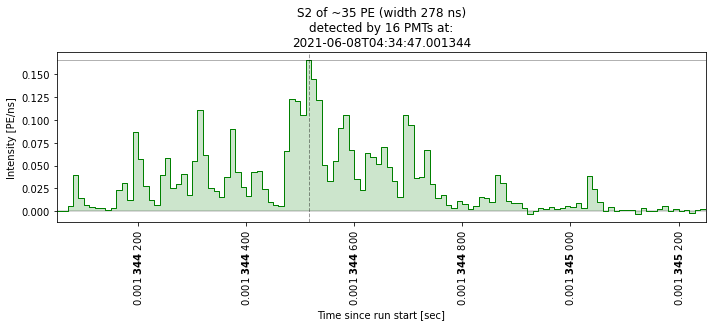

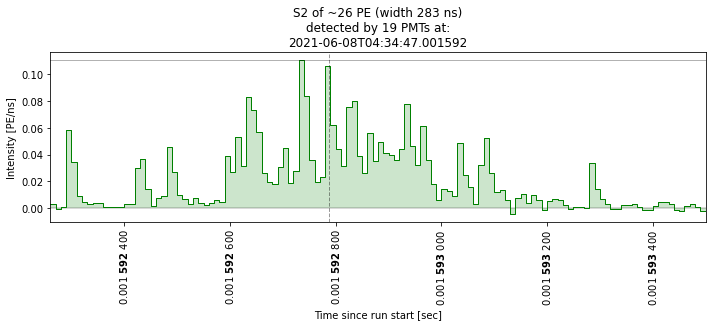

In [14]:
plot_some_peaks(peaks[peaks["area"] > 25], max_plots=2)

## Display populations
### Area vs width plot 
You see these plots a lot on Slac. We'll make a 2D histogram of two propperties of the peaks. Herefrom we try to isolatea population to look at the waveforms.

/tmp/jobs/17887550/ipykernel_46864/1171974014.py:9: RuntimeWarning: invalid value encountered in log10
  x, y = np.log10(x), np.log10(y)
/tmp/jobs/17887550/ipykernel_46864/1171974014.py:9: RuntimeWarning: divide by zero encountered in log10
  x, y = np.log10(x), np.log10(y)


Text(0.5, 1.0, 'Area vs width in log-log space of all populations\n10 s of data')

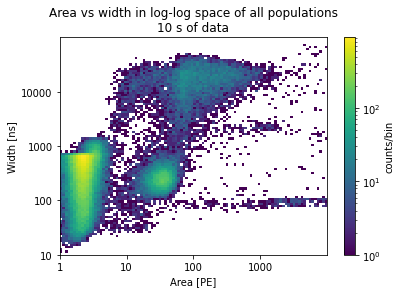

In [15]:
# All peaks
plots_area_vs_width(peaks, log=True, bins=100, range=[[0, 4], [1, 5]])
plt.title("Area vs width in log-log space of all populations\n10 s of data")

I want to zoom in on the population on the lower right. Therefore I reduce the range:

/tmp/jobs/17887550/ipykernel_46864/1171974014.py:9: RuntimeWarning: invalid value encountered in log10
  x, y = np.log10(x), np.log10(y)
/tmp/jobs/17887550/ipykernel_46864/1171974014.py:9: RuntimeWarning: divide by zero encountered in log10
  x, y = np.log10(x), np.log10(y)


Text(0.5, 1.0, 'Area vs width in log-log space zoomed on large S1s\n10 s of data')

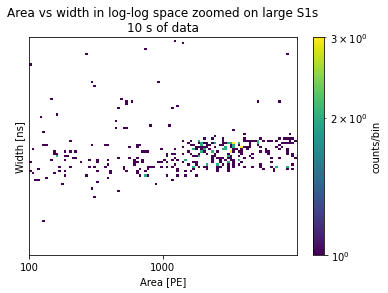

In [16]:
plots_area_vs_width(
    peaks, log=True, bins=100, range=[[2, 4], [1.5, 2.5]]
)  # zoomed wrt to previous plot!
plt.title("Area vs width in log-log space zoomed on large S1s\n10 s of data")

### Let's select this blob of peaks. 
For this I switch to lin-lin space rather than log-log as I'm too lazy to convert the selection I'm going to make from lin to log and vise versa.

Text(0.5, 1.0, 'Area vs width in lin-lin space zoomed on large S1s\n10 s of data')

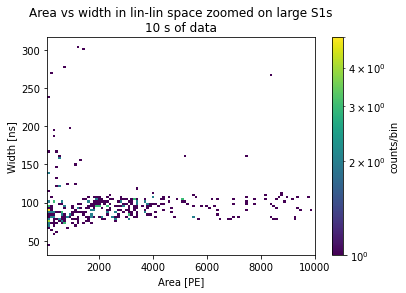

In [17]:
# Let's look in linear-space
plots_area_vs_width(peaks, log=False, bins=100, range=[[10**2, 10**4], [10**1.5, 10**2.5]])
plt.title("Area vs width in lin-lin space zoomed on large S1s\n10 s of data")

## Data selection
### Let's make a very rudimentary selection in this data

Below I'm going to draw a box around the blob as above and load some peaks therefrom. I suspect this are nice fat S1s.

In [18]:
# Parameters used for plot below
low_area = 2000
high_area = 8000
low_width = 80
high_width = 120

Text(0.5, 1.0, 'Area vs width in lin-lin space zoomed on large S1s\nwith selection\n10 s of data')

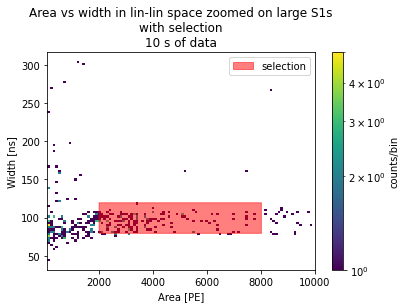

In [19]:
# select data in box
plots_area_vs_width(peaks, log=False, bins=100, range=[[10**2, 10**4], [10**1.5, 10**2.5]])

ax = plt.gca()
x = np.arange(low_area, high_area, 2)
y = np.full(len(x), low_width)
y2 = np.full(len(x), high_width)
ax.fill_between(x, y, y2, alpha=0.5, color="red", label="selection")
plt.legend()
plt.title("Area vs width in lin-lin space zoomed on large S1s\nwith selection\n10 s of data")

## Load more data from the selection.
For this I will use a 'selection string' this will reduce memory usage, see straxferno 0 and 1: https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon1t:aalbers:straxferno

I'm also going to load all the of data!

In [20]:
# Clear peaks from our namespace, this reduces our RAM usage (what usually crashes a notebook).
del peaks

In [21]:
%%time

# use selection string to load a lot of data
selected_peaks = st.get_array(
    run_id,
    targets="peak_basics",
    selection_str=(
        f"({high_area}>area) & (area>{low_area}) "
        f"& ({high_width}>range_50p_area) & (range_50p_area>{low_width})"
    ),
)

Loading peak_basics: |          | 0.00 % [00:00<?]

CPU times: user 1.87 s, sys: 1.46 s, total: 3.32 s
Wall time: 9.5 s


### Alternative method yielding the same (if all data were loaded)
The cell above does return the same results as this selection (only now we are taking the entire run instead of 10s):
```
mask = ((high_area>peaks['area'] ) & (peaks['area']>{low_area}) &
        high_width > peaks['range_50p_area'] & peaks['range_50p_area'] > low_area )

selected_peaks 
```

Text(0.5, 1.0, 'Area vs width in log-log space with selected S1s\nall data')

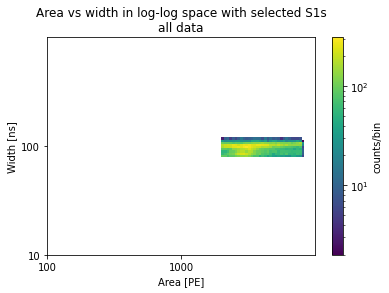

In [22]:
# Let's double check that we have the data we want in the area vs width space
plots_area_vs_width(selected_peaks, log=True, bins=100, range=[[2, 4], [1, 3]])
plt.title("Area vs width in log-log space with selected S1s\nall data")

Text(0.5, 1.0, 'Area vs width in lin-lin space with selected S1s\nall data')

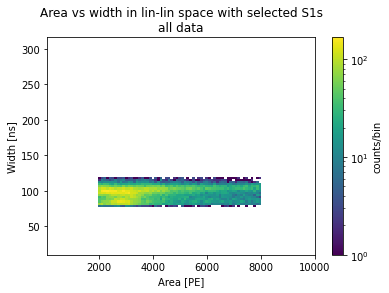

In [23]:
# select data in box
plots_area_vs_width(selected_peaks, log=False, bins=100, range=[[10**2, 10**4], [10**1, 10**2.5]])
plt.title("Area vs width in lin-lin space with selected S1s\nall data")

## Plotting waveforms
Let's check that these are indeed big S1s:

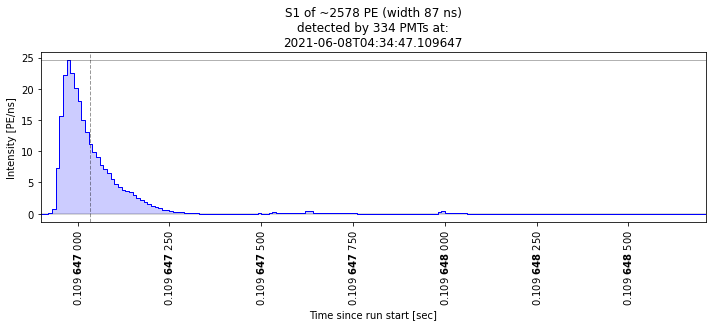

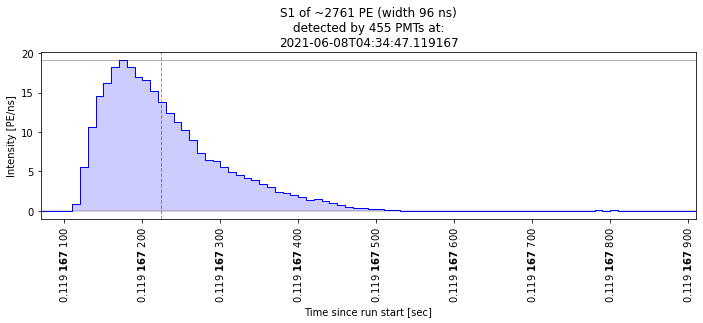

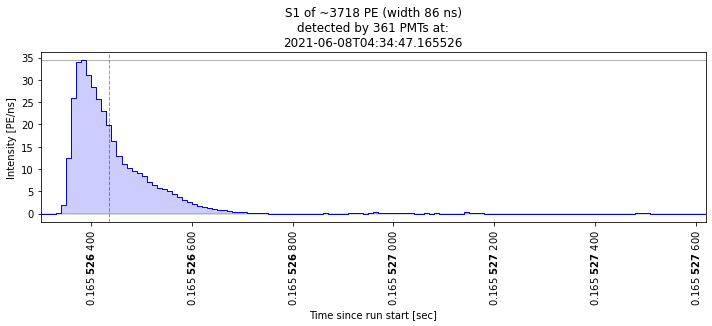

In [24]:
plot_some_peaks(selected_peaks)

Nice, we made a simple cut and checked that some waveforms are of the kind we expected. Of course we can do more elaborate cuts and check the other dimensions of the parameter space. Very interesting times to be an analyst! 